* Llama-index library Exploration
* Creation of strucutred outputs from LLM outputs.

# Setup

## Packages

In [1]:
!pip install llama-index llama-index-llms-groq llama-index-embeddings-huggingface faiss-cpu \
llama-index-llms-huggingface llama-index-vector-stores-faiss llama-index-llms-gemini llama-index-embeddings-gemini\
llama-index-finetuning python-dotenv -q
!pip install --upgrade sentence_transformers -q
!python -m nltk.downloader punkt_tab -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5

## Imports

In [2]:
import os
import matplotlib.pyplot as plt
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core import SimpleDirectoryReader
from llama_index.core.indices.vector_store import VectorStoreIndex
from llama_index.vector_stores.faiss import FaissVectorStore
from llama_index.core.storage.storage_context import StorageContext
from nltk.tokenize import sent_tokenize, word_tokenize
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Settings
from llama_index.core import load_index_from_storage
from llama_index.llms.gemini import Gemini
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.finetuning.embeddings.common import generate_qa_embedding_pairs, EmbeddingQAFinetuneDataset
# Import HitRate and MRR from llama_index
from llama_index.core.evaluation.retrieval.metrics import HitRate, MRR
# RetrieverEvaluator
from llama_index.core.evaluation import RetrieverEvaluator
import numpy as np
import faiss
import pickle

## Variables

In [3]:
# Variables
from dotenv import load_dotenv
load_dotenv("/content/drive/MyDrive/Colab Notebooks/env")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
INDEX_DIR = "/content/drive/MyDrive/Colab Notebooks/indexes"
LLAMA_INDEX_DIR = "/content/drive/MyDrive/Colab Notebooks/llama-index"
EXP_DIR = os.path.join(LLAMA_INDEX_DIR, "exp1")
# Functionize the index directory creation and clean up
INDEX_FAISS_PAUL_GRAHAM = os.path.join(INDEX_DIR, "faiss_hnsw_paul_graham")
INDEX_FAISS_PAUL_GRAHAM_L2 = os.path.join(INDEX_DIR, "faiss_paul_graham_l2")
INDEX_FAISS_PAUL_GRAHAM_L2_v2 = os.path.join(INDEX_DIR, "faiss_paul_graham_l2_v2")
os.makedirs(INDEX_FAISS_PAUL_GRAHAM, exist_ok=True)
os.makedirs(INDEX_FAISS_PAUL_GRAHAM_L2, exist_ok=True)
os.makedirs(INDEX_FAISS_PAUL_GRAHAM_L2_v2, exist_ok=True)
os.makedirs(EXP_DIR, exist_ok=True) # Diretory to store all artifacts(nodes, indexes, datasets)

## Download Models

In [ ]:
embed_model = HuggingFaceEmbedding(model_name="Alibaba-NLP/gte-Qwen2-1.5B-instruct")
# llm = HuggingFaceLLM(model_name="HuggingFaceTB/SmolLM-1.7B")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
llm_gemini = Gemini(
    model="models/gemini-1.5-flash",
    api_key=GEMINI_API_KEY,
)
embed_model_gemini = GeminiEmbedding(
    model="models/text-embedding-004",
    api_key=GEMINI_API_KEY,
)

# Implementing and Optimizing a RAG pipeline with LLamaIndex

1. Dataset - Paul Graham Essay. (Using a small dataset for compute limitations on embeddings creations)
2.Embedding model - `gte-Qwen2-1.5B-instruct`
3. LLM - `SmolLM-1.7B`

Using small models for Embeddings, LLM due to compute.

## Simple RAG Pipeline

### Loading Data

In [ ]:
!mkdir data
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/paul_graham/paul_graham_essay.txt' -O 'data/paul_graham_essay.txt'

--2025-01-28 05:05:06--  https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/paul_graham/paul_graham_essay.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75042 (73K) [text/plain]
Saving to: ‘data/paul_graham_essay.txt’

data/paul_graham_es 100%[===================>]  73.28K  --.-KB/s    in 0.03s   

2025-01-28 05:05:07 (2.32 MB/s) - ‘data/paul_graham_essay.txt’ saved [75042/75042]



In [ ]:
documents = SimpleDirectoryReader("./data/").load_data()

In [ ]:
print(f"Number of documents: {len(documents)}")

Number of documents: 1


In [ ]:
# Loads the text data, creates an id_, metadata has file details(path, name, type, size, creation date, modification date etc.)
# text_resource has the main text data
# SimpleDirectoryReader is implemented to load different datatypes(txt, html, markdown etc).
print(documents[0].__dict__.keys())
print("-"*50)
print(documents[0].__dict__["metadata"])

dict_keys(['id_', 'embedding', 'metadata', 'excluded_embed_metadata_keys', 'excluded_llm_metadata_keys', 'relationships', 'metadata_template', 'metadata_separator', 'text_resource', 'image_resource', 'audio_resource', 'video_resource', 'text_template'])
--------------------------------------------------
{'file_path': '/content/data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2025-01-23', 'last_modified_date': '2025-01-23'}


### Ingestion

To ingest data with LlamaIndex, we've to create nodes out of Documents with node_parsers.

LlamaIndex provides variety of Splitters and Parsers. [Docs](https://docs.llamaindex.ai/en/stable/api_reference/node_parsers/sentence_window/).

Here, we'll use a simple SentenceSplitter.

In [ ]:
sentences = sent_tokenize(documents[0].text)

In [ ]:
print(f"Number of sentences with nltk tokenizer: {len(sentences)}")

Number of sentences with nltk tokenizer: 756


In [ ]:
print(f"Total number of words: {len(documents[0].text)}")

Total number of words: 75011


In [ ]:
sentence_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=24)

In [ ]:
# Create nodes/chunks
nodes = sentence_splitter.get_nodes_from_documents(documents)

In [ ]:
print(f"Number of nodes: {nodes.__len__()}")

Number of nodes: 37


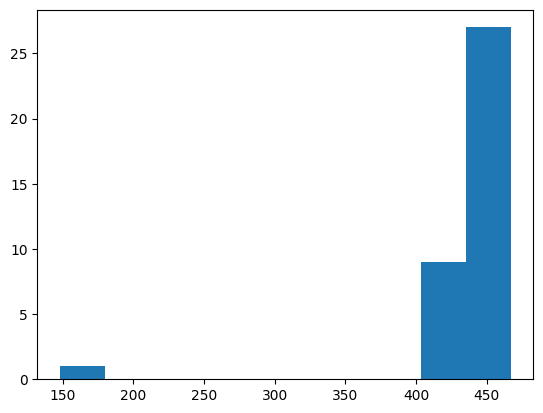

In [ ]:
# See distirbution of chunks
chunk_sizes = [len(word_tokenize(node.text)) for node in nodes]
plt.hist(chunk_sizes)
plt.show()

In [ ]:
print(f"Average chunk size: {np.mean(chunk_sizes)}")

Average chunk size: 437.97297297297297


In [ ]:
print(f"95th percentile: {np.percentile(chunk_sizes, 95)}")

95th percentile: 467.0


One chunk is outlier(150) might be the last text.

### Indexing

Nodes/Chunks are created. Let's create embeddings and the index on top of it.
We'll use an In-Memory vector store - Faiss for this implementaion.

In [ ]:
embed_dim = embed_model.get_text_embedding("Hello").__len__()
embed_dim

1536

In [ ]:
M = 4 # Number of neighbours per vertex
faiss_index = faiss.IndexHNSWFlat(embed_dim, M)

In [ ]:
faiss_index.hnsw.max_level

-1

In [ ]:
INDEX_EXISTS = len(os.listdir(INDEX_FAISS_PAUL_GRAHAM)) > 0
INDEX_EXISTS

True

In [ ]:
vector_store = FaissVectorStore(faiss_index=faiss_index)
storage_context = StorageContext.from_defaults(
    vector_store=vector_store,
)

NEW_INDEX = True # Optional parameter to override existing
if not INDEX_EXISTS or NEW_INDEX:
  vector_index = VectorStoreIndex(
      nodes,
      storage_context=storage_context,
      embed_model=embed_model,
      show_progress=True,

  )
  vector_index.storage_context.persist(INDEX_FAISS_PAUL_GRAHAM) # Store index

Generating embeddings:   0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:
False or True

True

HNSW Faiss Index with gte-qwen-1.5-Instruct embeddings takes around 20minutes.

* Index Dimension: 1356
* HNSW Max Neighbor pers vertex: 8

In [ ]:
# Load index
Settings.embed_model = embed_model
if INDEX_EXISTS:
  loaded_vector_store = FaissVectorStore.from_persist_dir(persist_dir=INDEX_FAISS_PAUL_GRAHAM)
  loaded_storage_context = StorageContext.from_defaults(
      vector_store=loaded_vector_store,
      persist_dir=INDEX_FAISS_PAUL_GRAHAM, # Required to load index from storage.
  )
  loaded_index = load_index_from_storage(storage_context=loaded_storage_context)

### Querying

We can use the index as query engine. QueryEngine in LlamaIndex enables us to query the created index with Natural Language and generate answers on the query. What lies under the QueryEngine is an Retriever and Generation.

In [ ]:
# simple querying
Settings.llm = llm
query_engine = vector_index.as_query_engine(top_k=5)
response = query_engine.query("What did the author do growing up?")
print(response)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


�???????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????


top_k=5, chunk_size=512, 1.7BLLM, 1536dim, 2CPUs and the generation nearly takes close to 10minutes(1st iter), 43minutes(2nd iter) for just ?'s lol.

Generation time is not consistent.

This is the limitations with limited compute and LargeLanguage Models. If compute and time is available go with Open-Source models. Application building is valued higher irrespective of cost and transperancy opt for Maintained models.

To get more visisblity, let's split the retriever and generation for evaluation purposes.

In [ ]:
retriever = vector_index.as_retriever(top_k=5)
top_k_nodes = retriever.retrieve("What did the author do growing up?")

`retriever.retrieve` calls [query()](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/vector_stores/simple.py). This finally calls the [get_topk_embeddings()](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/indices/query/embedding_utils.py#L11), which calls [similarity()](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/base/embeddings/base.py). This by default uses `cosine similarity`.

Other similarity methods available are:
1. Euclidean distance.
2. Dot Product.

Retriever returns `NodeWithScore` object.

In [ ]:
len(top_k_nodes)

2

In [ ]:
top_k_nodes[0].__dict__.keys()

dict_keys(['node', 'score'])

In [ ]:
scores = [node.score for node in top_k_nodes]
scores

[1.1232140064239502, 1.1505811214447021]

Default Similarity method is cosine but the scores are more than 1. Cosine Similarity Score ranges between 0 and 1. Why? Let's reverify this again with Building a retriever from scratch.


In [ ]:
top_k_nodes[0].node

TextNode(id_='cff427a0-1a28-456f-a178-6c04211b0caa', embedding=None, metadata={'file_path': '/content/data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2025-01-21', 'last_modified_date': '2025-01-21'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='3c1a86b4-8077-410b-b50c-d460508cc38d', node_type='4', metadata={'file_path': '/content/data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2025-01-21', 'last_modified_date': '2025-01-21'}, hash='0c3c3f46cac874b495d944dfc4b920f6b68817dbbb1699ecc955d1fafb2bf87b'), <NodeRelationship.PREVIOUS: '2'>: Related

## Retriever Evaluation

Now, we've a RAG pipeline. Next step is to evaluate it. We don't have a dataset to evaluate retrieval. Let's create a Synthetic Dataset with chunks.

We'll use Gemini going Forward.

### Dataset

This section covers:
1. qa dataset creation
2. Save and Load

In [ ]:
Settings.llm = llm_gemini

[`generate_context_question_pairs()`](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/llama_dataset/legacy/embedding.py) from llama-index, we can generate questions. Prompt used:

```
DEFAULT_QA_GENERATE_PROMPT_TMPL = """\
Context information is below.

---------------------
{context_str}
---------------------

Given the context information and not prior knowledge.
generate only questions based on the below query.

You are a Teacher/ Professor. Your task is to setup \
{num_questions_per_chunk} questions for an upcoming \
quiz/examination. The questions should be diverse in nature \
across the document. Restrict the questions to the \
context information provided."
"""
```

Generates questions, Extracts question with regex `re.sub(r"^\d+[\).\s]", "", question)`. Evaluates only the number of questions parameter is matched.

In [ ]:
import inspect
inspect.signature(generate_qa_embedding_pairs).parameters.keys()

odict_keys(['nodes', 'llm', 'qa_generate_prompt_tmpl', 'num_questions_per_chunk', 'retry_limit', 'on_failure', 'save_every', 'output_path', 'verbose'])

In [ ]:
# Generate QA pairs
qa_dataset = generate_qa_embedding_pairs(nodes=nodes, llm=llm_gemini, num_questions_per_chunk=1, verbose=True)

 43%|████▎     | 16/37 [00:26<00:33,  1.60s/it]WARNING:tornado.access:429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1037.43ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 1/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1037.43ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 2/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1163.79ms


 46%|████▌     | 17/37 [00:30<00:46,  2.33s/it]WARNING:tornado.access:429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1224.17ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 1/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1224.17ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 2/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1164.25ms


 49%|████▊     | 18/37 [00:34<00:51,  2.70s/it]

Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 3/3...
Skipping node eb688395-95d4-409f-98ae-bc090daac9cc after 3 retries.
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1138.75ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 1/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1163.97ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 2/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 990.36ms


 51%|█████▏    | 19/37 [00:37<00:51,  2.86s/it]

Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 3/3...
Skipping node 2335b6bb-27c6-47c0-a78a-86df0828fcc3 after 3 retries.
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1062.86ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 1/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1240.18ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 2/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1164.88ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 3/3...429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1214.83ms


 54%|█████▍    | 20/37 [00:41<00:52,  3.10s/it]


Skipping node e7528987-0b46-4a12-883b-333b63e85724 after 3 retries.


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 1/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1189.83ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 2/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1343.64ms


 57%|█████▋    | 21/37 [00:45<00:53,  3.32s/it]WARNING:tornado.access:429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1300.06ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 3/3...
Skipping node e4a1dac8-fdcc-44d0-86e9-acafc6b8c346 after 3 retries.
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1300.06ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 1/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1188.01ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 2/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1265.42ms


 59%|█████▉    | 22/37 [00:49<00:52,  3.51s/it]

Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 3/3...
Skipping node 5bd9c934-709c-45fc-8db7-2d3190038f2e after 3 retries.
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1442.01ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 1/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1240.25ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 2/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1340.93ms


 62%|██████▏   | 23/37 [00:53<00:50,  3.62s/it]

Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 3/3...
Skipping node 0a1b5ec7-26ea-47f4-8ff4-23045a95e236 after 3 retries.
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1290.33ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 1/3...429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1189.30ms



Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 2/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1113.71ms


 65%|██████▍   | 24/37 [00:56<00:46,  3.56s/it]

Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 3/3...
Skipping node e1d90b6f-3fe8-4f9c-93eb-50f15cb41206 after 3 retries.
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1087.66ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 1/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1168.66ms


Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 2/3...
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1190.47ms


 68%|██████▊   | 25/37 [01:00<00:42,  3.58s/it]

Error querying LLM: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).. Retrying 3/3...
Skipping node 719b355e-f219-4e3d-87ad-f4bc1f48c376 after 3 retries.
429 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1215.06ms


100%|██████████| 37/37 [01:20<00:00,  2.19s/it]

Final dataset saved.


In [ ]:
type(qa_dataset)

llama_index.finetuning.embeddings.common.EmbeddingQAFinetuneDataset

In [ ]:
import pickle
pickle.dump(qa_dataset, open("/content/drive/MyDrive/Colab Notebooks/datasets/li-qa-dataset-pg.pkl", "wb"))

In [ ]:
import pickle
qa_loaded = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/datasets/li-qa-dataset-pg.pkl", "rb"))

In [ ]:
qa_loaded_ds = EmbeddingQAFinetuneDataset.model_validate(qa_loaded)

In [ ]:
qa_dataset.__dict__.keys()

dict_keys(['queries', 'corpus', 'relevant_docs', 'mode'])

In [ ]:
query_id = list(qa_dataset.__dict__["queries"])[0]
query_id, qa_dataset.__dict__.get("queries").get(query_id)

('a4720f13-80d2-44dc-a0ed-ab441f3a2ac9',
 "What limitations of the IBM 1401 computer hampered the author's early programming efforts, and what specific example illustrates this limitation?")

In [ ]:
node_id = qa_dataset.__dict__["relevant_docs"][query_id]
node_id

['124db005-422f-4bbb-901f-3b5dea279c4b']

In [ ]:
# node_ids to text map
ids_to_text = {node.id_: node.text for node in nodes}
ids_to_text.get(node_id[0])

'What I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.\n\nThe first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district\'s 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain\'s lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.\n\nThe language we used was an early version of Fortran. You had to type programs on punch cards, then stack

Ouptut from `generate_qa_embedding_pairs()`, returns:
1. queries --> Dict lookup {uuid: question_str}
2. relevant_docs --> Dict lookup {query_uuid: [node_ids]}

In [ ]:
eval_response = llm_gemini.complete(
    f"""
    Given a question and context, evaluate how relevant it is to the context. Given a Flag on Relevancy. True or False are the flags.
    Return a dict ouptut with rating, explaination.
    The dict output has to be clean without any new lines
    Question: {qa_dataset.__dict__.get("queries").get(query_id)}
    Context: {ids_to_text.get(node_id[0])}
    Answer:
    """
)

In [ ]:
eval_response.text

'```json\n{"rating": true, "explanation": "The context explicitly discusses the author\'s early programming experiences on an IBM 1401, mentioning the limitations of using punch cards as the sole input method and the lack of interactive feedback.  The author\'s inability to find suitable data on punch cards and the resulting inability to create interesting programs directly addresses the question\'s prompt for limitations and a specific example. The anecdote about the program that didn\'t terminate also illustrates a limitation of the system\'s lack of time-sharing."}\n```\n'

### Structured outputs from LLM output

Below cells gives an intution of abstraction in llama-index, langchain and other frameworks in creating strucutred outputs with LLM text.

Regex is power!!🔥

In [ ]:
# Regex from langchain to extract the JSON output
import re
json_ = re.search(r"\{.*\}", eval_response.text.strip(), re.MULTILINE | re.IGNORECASE | re.DOTALL)
json_.group()

'{"rating": true, "explanation": "The context explicitly discusses the author\'s early programming experiences on an IBM 1401, mentioning the limitations of using punch cards as the sole input method and the lack of interactive feedback.  The author\'s inability to find suitable data on punch cards and the resulting inability to create interesting programs directly addresses the question\'s prompt for limitations and a specific example. The anecdote about the program that didn\'t terminate also illustrates a limitation of the system\'s lack of time-sharing."}'

There is some conversion or cleaning done and something is like below is ran to create strucutred outputs.

In [ ]:
from pydantic import BaseModel
class Sample(BaseModel):
  rating: bool
  explanation: str

sample = Sample.model_validate({"rating": True, "explanation": "The context explicitly discusses the author\'s early programming experiences on an IBM 1401, mentioning the limitations of using punch cards as the sole input method and the lack of interactive feedback.  The author\'s inability to find suitable data on punch cards and the resulting inability to create interesting programs directly addresses the question\'s prompt for limitations and a specific example. The anecdote about the program that didn\'t terminate also illustrates a limitation of the system\'s lack of time-sharing."})
sample

Sample(rating=True, explanation="The context explicitly discusses the author's early programming experiences on an IBM 1401, mentioning the limitations of using punch cards as the sole input method and the lack of interactive feedback.  The author's inability to find suitable data on punch cards and the resulting inability to create interesting programs directly addresses the question's prompt for limitations and a specific example. The anecdote about the program that didn't terminate also illustrates a limitation of the system's lack of time-sharing.")

We can run the above prompt and stor the relevancy of question to context and store them.

The chunks are really big, Let's check a single question if it's relevant to chunk.(This should be good but checking or creating evaluation datasets is good as it determines your performance of the application or pipeline).

In [ ]:
vars(nodes[0])

{'id_': '124db005-422f-4bbb-901f-3b5dea279c4b',
 'embedding': None,
 'metadata': {'file_path': '/content/data/paul_graham_essay.txt',
  'file_name': 'paul_graham_essay.txt',
  'file_type': 'text/plain',
  'file_size': 75042,
  'creation_date': '2025-01-21',
  'last_modified_date': '2025-01-21'},
 'excluded_embed_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'excluded_llm_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'relationships': {<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='3c1a86b4-8077-410b-b50c-d460508cc38d', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/content/data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2025-01-21', 'last_modified_date': '2025-01-21'}, hash='0c3c3f46cac874b495d944dfc4b920f6b68817dbb

In [ ]:
nodes[1].id_

'5fd078d3-a893-44ef-9673-ca0fe098360f'

### Retriever

We'll use two metrics to evaluate the retrieved docs:
1. Hit Rate: How often relevant context is present in top_k_docs
2. Mean Reciprocal Rank(MRR): In which top_k docs relevant context is found(whether it's 1st, 2nd or 3rd and so on.). This score decreases as it goes down the list of docs.

[Metrics Implementation](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/evaluation/retrieval/metrics.py). We can get a granular and better score by importing metrics from here and passing the metrics directly to `RetrieverEvaluator` instead of using `RetrieverEvaluator.from_metric_names()`

We already have the dataset with Syntheic Question ids mapped with their respective relevant document ids in `qa_dataset`.

`RetrieverEvaluator` evaluates `qa_dataset` on the metrics passed.

#### Loaded Index

In [ ]:
# Evaluate for a single k
retriever = loaded_index.as_retriever(top_k=2)
# Creates a retriever with implementation of respective metrics.
evaluator = RetrieverEvaluator.from_metric_names(
    retriever=retriever,
    metric_names=["hit_rate", "mrr"],
)
# Provides only async evaluation
results = await evaluator.aevaluate_dataset(dataset=qa_loaded_ds)

ValueError: Retrieved ids and expected ids must be provided

Why the error?

In [ ]:
retriever = vector_index.as_retriever(similarity_top_k=2)
retriever.retrieve("What did the author do growing up?")

[NodeWithScore(node=TextNode(id_='3e94e0c4-7ba9-4a11-ad4f-80fb2d55cc09', embedding=None, metadata={'file_path': '/content/data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2025-01-22', 'last_modified_date': '2025-01-22'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='ad6fee52-f00f-4224-97a5-d23758b3a213', node_type='4', metadata={'file_path': '/content/data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2025-01-22', 'last_modified_date': '2025-01-22'}, hash='0c3c3f46cac874b495d944dfc4b920f6b68817dbbb1699ecc955d1fafb2bf87b'), <NodeRelationship.PRE

In [ ]:
retrieverl = loaded_index.as_retriever(similarity_top_k=2)
retrieverl.retrieve("What did the author do growing up?")

[]

In [ ]:
len(loaded_index.docstore.docs.keys())

37

In [ ]:
type(loaded_index), type(vector_index)

(llama_index.core.indices.vector_store.base.VectorStoreIndex,
 llama_index.core.indices.vector_store.base.VectorStoreIndex)

In [ ]:
qe = loaded_index.as_query_engine()
qe.query("What did the author do growing up?")

Response(response='Empty Response', source_nodes=[], metadata=None)

In [ ]:
qe = vector_index.as_query_engine()
qe.query("What did the author do growing up?")

Response(response="The provided text mentions the author spent a lot of time at the Carnegie Institute as a child.  Beyond that, the text does not describe the author's childhood activities.\n", source_nodes=[NodeWithScore(node=TextNode(id_='3e94e0c4-7ba9-4a11-ad4f-80fb2d55cc09', embedding=None, metadata={'file_path': '/content/data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2025-01-22', 'last_modified_date': '2025-01-22'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='ad6fee52-f00f-4224-97a5-d23758b3a213', node_type='4', metadata={'file_path': '/content/data/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'f

Loaded Index Retriever and Query Engine doesn't work but VectorIndex works.

This is a problem. Why?

Assume you're deploy this system in Containerized environment, We can't create an index during scale up, restart etc. This is waste and increases downtime.

Find a fix or discuss.

#### New index

In [ ]:
# Evaluate for a single k
from llama_index.core.evaluation import RetrieverEvaluator
import asyncio
retriever = vector_index.as_retriever(top_k=2)
evaluator = RetrieverEvaluator.from_metric_names(
    retriever=retriever,
    metric_names=["hit_rate", "mrr"],
)
loop = asyncio.get_event_loop()
# Provides only async evaluation
results = await evaluator.aevaluate_dataset(dataset=qa_loaded_ds, show_progress=True)

100%|██████████| 29/29 [01:36<00:00,  3.31s/it]


In [ ]:
vars(results[0])

{'query': "What limitations of the IBM 1401 computer hampered the author's early programming efforts, and what specific example illustrates this limitation?",
 'expected_ids': ['e4412451-913f-4443-8984-6ec1976b3779'],
 'expected_texts': None,
 'retrieved_ids': ['abe47102-de9f-464f-9e05-fb5bb4ccbf5f',
  '3e94e0c4-7ba9-4a11-ad4f-80fb2d55cc09'],
 'retrieved_texts': ["Then in November, right in the middle of a painting, I ran out of steam. Up till that point I'd always been curious to see how the painting I was working on would turn out, but suddenly finishing this one seemed like a chore. So I stopped working on it and cleaned my brushes and haven't painted since. So far anyway.\n\nI realize that sounds rather wimpy. But attention is a zero sum game. If you can choose what to work on, and you choose a project that's not the best one (or at least a good one) for you, then it's getting in the way of another project that is. And at 50 there was some opportunity cost to screwing around.\n\nI 

We can pass arg `mode` to evaluate it for text as well. It's an enum and accepts two values. `text` and `image.`

So Evaluator runs retrieval evaluation against each query and returns `llama_index.core.evaluation.retrieval.base.RetrievalEvalResult` object. What we need is `metric_dict` which has the metrics we need. Let's put all the results into a dataframe and group them by K and calculate the mean of metrics.

Time Taken for Single K, 29 data points is 1 minute.

In [ ]:
type(results[0])

llama_index.core.evaluation.retrieval.base.RetrievalEvalResult

In [ ]:
# Evaluating for multiple K values
from llama_index.core.evaluation import RetrieverEvaluator
K_VALUES = range(1,5,1)
all_evals = []
for k in K_VALUES:
  print(f"Evaluating for k={k}")
  retriever = vector_index.as_retriever(top_k=k)
  evaluator = RetrieverEvaluator.from_metric_names(
      retriever=retriever,
      metric_names=["hit_rate", "mrr"],
  )
  eval_results = await evaluator.aevaluate_dataset(qa_loaded_ds, show_progress=True)
  all_evals.append(eval_results)

Evaluating for k=1


100%|██████████| 29/29 [01:30<00:00,  3.12s/it]


Evaluating for k=2


100%|██████████| 29/29 [01:25<00:00,  2.96s/it]


Evaluating for k=3


100%|██████████| 29/29 [01:28<00:00,  3.05s/it]


Evaluating for k=4


100%|██████████| 29/29 [01:27<00:00,  3.02s/it]


In [ ]:
len(all_evals)

4

In [ ]:
metrics = []
for k, k_result in enumerate(all_evals):
  for query_result in k_result:
      metrics.append({
          "k": k,
          "hit_rate": query_result.metric_dict["hit_rate"].score,
          "mrr": query_result.metric_dict["mrr"].score,
          # For visibility
          "query": query_result.query,
          "expected_ids": query_result.expected_ids,
          "predicted_ids": query_result.retrieved_ids,
      })

In [ ]:
len(metrics)

116

In [ ]:
import pandas as pd
metrics_df = pd.DataFrame(metrics)

In [ ]:
metrics_df.head()

,k,hit_rate,mrr,query,expected_ids,predicted_ids
0,0,0.0,0.0,What limitations of the IBM 1401 computer hamp...,[e4412451-913f-4443-8984-6ec1976b3779],"[ce40434e-a6e6-4a61-85c9-dad214d4f4ae, 7294929..."
1,0,0.0,0.0,What factors influenced the author's decision ...,[c46ea1fb-acbb-4bae-81db-651faaabe9c5],"[095132a0-ee44-4df5-bf80-9a716291325d, 041dbc3..."
2,0,0.0,0.0,What factors contributed to the author's decis...,[d717506d-a279-42fd-be75-95b22fd36127],"[72949294-13cc-4ba4-95c3-170176cf581e, ce40434..."
3,0,0.0,0.0,Describe the author's disillusionment with AI ...,[4f0d7136-3bf3-4099-924a-1c78598434a9],"[095132a0-ee44-4df5-bf80-9a716291325d, 69458f9..."
4,0,0.0,0.0,What realization did the author have while vie...,[f2c37dec-1fde-4662-9da5-ed9784905050],"[041dbc31-6ec2-41ba-aa81-f622168974c5, a497dc7..."


In [ ]:
metrics_df.k.unique()

array([0, 1, 2, 3])

In [ ]:
metrics_df.groupby("k")["hit_rate"].mean(), metrics_df.groupby("k")["mrr"].mean()

(k
 0    0.0
 1    0.0
 2    0.0
 3    0.0
 Name: hit_rate, dtype: float64,
 k
 0    0.0
 1    0.0
 2    0.0
 3    0.0
 Name: mrr, dtype: float64)

In [ ]:
# from llama_index.core.evaluation.retrieval.metrics import HitRate, MRR
# To Do, low level RetrieverEvaluation directly with metrics.

Retrieval metrics is zero. No retrieved docs match the questions. This might be due to one of the below reasons:
1. Syntheic Data Quality(Depends on LLM, Because it's generated with a prompt and the text).
2. Chunk(Chunk might be big for generation, number of questions(1) might be small). Let's play with these and see if we can generate a better dataset.
3. Embeddings is not capturing the similarity. (Think of it questions is generated by Gemini, but embeddings model is qwen.)

### DatasetV1

We'll create a new dataset with different chunking strategy.

#### Changes

1. Chunk Size reduced
2. Faiss Index HNSW --> L2(Euclidean)
3. gte-qwen-embedding --> text-embedding-004(Gemini)

In [ ]:
# Create nodes/chunks
sentence_splitter_smal = SentenceSplitter(chunk_size=256, chunk_overlap=32)
nodes = sentence_splitter_smal.get_nodes_from_documents(documents)

In [ ]:
len(nodes)

83

In [ ]:
pickle.dump(nodes, open(os.path.join(EXP_DIR, "pg-nodes-256c-32co-gemini.pkl"), "wb"))

In [ ]:
# Test
test_embedding = embed_model_gemini.get_text_embedding("Hello")
len(test_embedding)

768

In [ ]:
embed_dim_v1 = len(test_embedding)

Local embeddings took 10minutes for the same document with higher chunk size but Maintained Embeddings accessed via API is real quick. The Decoupling is powerful in this case.

But with cost in mind it's best to have a load and save mechanism to avoid generating embeddings for same dataset and embedding model.

Let's try saving with L2, because HNSW didn't workout.

***Peculiar problem with index creation***

Indexes get's added to `storage_context.index_store` as a list. And the specific index_id, nodes_dict is used when using the index as retriever. In llama-index even after instantiating a new `StorageContext` the id's `StorageContext.index_store.index_structs()` a new index is created and the ids in `StorageContext.index_store.index_structs()[idx].node_dict` ids gets incremented. Problem? While retrieve with index, it expects keys from 0. But due to the incrementic nature, this doesn't work.

```
index_v1 = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
    embed_model=embed_model_gemini,
    show_progress=True,
)
```
Extends the indexes list and increments the id's in nodes_dict.

Let's recreate a new index. To do that a new storage context is required. There's also function to delete_indexes with `delete_index_struct()`. We can use this to clean up the existing indices as well. The `node_dict` ids increment continues even after this.

* `storage_context.index_store.index_structs()` To get the list of indices.
* Each item has below attributes`dict_keys(['index_id', 'summary', 'nodes_dict', 'doc_id_dict', 'embeddings_dict'])
`.

* Use the `index_id` to access a specific index.

In [ ]:
# Create index
faiss_index = faiss.IndexFlatL2(embed_dim_v1)
vector_store = FaissVectorStore(faiss_index=faiss_index)
storage_context = StorageContext.from_defaults(
    vector_store=vector_store,
)

In [ ]:
# Check for any existing indices
storage_context.index_store.index_structs()

[]

In [ ]:
# Create new index
index_faiss_l2 = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
    embed_model=embed_model_gemini,
    show_progress=True,
)

Generating embeddings:   0%|          | 0/83 [00:00<?, ?it/s]

In [ ]:
# Assert all nodes are present in nodes dict
assert storage_context.index_store.index_structs()[0].nodes_dict.__len__() == len(nodes)
# Assert indexes are correct
assert int(list(storage_context.index_store.index_structs()[0].nodes_dict.keys())[-1]) == len(nodes)-1

In [ ]:
# Store index
# Index dir
EXP_INDEX_DIR = os.path.join(EXP_DIR, "index")
os.makedirs(os.path.join(EXP_DIR, "index"), exist_ok=True)
index_faiss_l2.storage_context.persist(EXP_INDEX_DIR)

In [ ]:
# load index from disk
EXP_INDEX_DIR = os.path.join(EXP_DIR, "index")
Settings.llm = llm_gemini
Settings.embed_model = embed_model_gemini
vector_store = FaissVectorStore.from_persist_dir(EXP_INDEX_DIR)
storage_context = StorageContext.from_defaults(
    vector_store=vector_store, persist_dir=EXP_INDEX_DIR,
)
index = load_index_from_storage(storage_context=storage_context)

In [ ]:
# Test loaded index
retriever = index.as_retriever(similarity_top_k=2)
retrieved_nodes = retriever.retrieve("What did the author do growing up?")

#### Generation

In [ ]:
slice_idx = list(range(0, len(nodes), 10))
slice_idx.append(len(nodes)) if len(nodes) not in slice_idx else None
# Create data slices
slices = []
for i in range(len(slice_idx)-1):
  slices.append(nodes[slice_idx[i]:slice_idx[i+1]])

In [ ]:
len(slice_idx)

10

In [ ]:
len(nodes)

83

In [ ]:
slices[0][0].text == slices[1][0].text

False

In [ ]:
# Generate QA dataset
import time
qa_datasets = []
for idx, data_slice in enumerate(slices):
  qa_dataset_gen = generate_qa_embedding_pairs(
      nodes=data_slice,
      llm=llm_gemini,
      num_questions_per_chunk=2,
      verbose=True,
      output_path=f"qa_ft_ds_{idx}.json", # If iterating specify this. Otherwise on subsequent iterations default value qa_finetune_dataset.json will be loaded and generation will be skipped.
      )
  qa_datasets.append(qa_dataset_gen)
  time.sleep(30)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:20,  2.23s/it]

 20%|██        | 2/10 [00:04<00:15,  1.98s/it]

 30%|███       | 3/10 [00:06<00:13,  1.98s/it]

 40%|████      | 4/10 [00:07<00:11,  1.96s/it]

 50%|█████     | 5/10 [00:09<00:09,  1.95s/it]

 60%|██████    | 6/10 [00:12<00:08,  2.03s/it]

 70%|███████   | 7/10 [00:14<00:06,  2.08s/it]

 80%|████████  | 8/10 [00:16<00:04,  2.10s/it]

 90%|█████████ | 9/10 [00:18<00:01,  2.00s/it]

100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


Final dataset saved.




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:15,  1.76s/it]

 20%|██        | 2/10 [00:03<00:14,  1.84s/it]

 30%|███       | 3/10 [00:05<00:13,  1.92s/it]

 40%|████      | 4/10 [00:07<00:11,  1.93s/it]

 50%|█████     | 5/10 [00:09<00:09,  1.93s/it]

 60%|██████    | 6/10 [00:11<00:07,  1.90s/it]

 70%|███████   | 7/10 [00:13<00:05,  1.83s/it]

 80%|████████  | 8/10 [00:15<00:03,  1.89s/it]

 90%|█████████ | 9/10 [00:16<00:01,  1.82s/it]

100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


Final dataset saved.




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:17,  1.90s/it]

 20%|██        | 2/10 [00:03<00:15,  1.95s/it]

 30%|███       | 3/10 [00:06<00:14,  2.03s/it]

 40%|████      | 4/10 [00:08<00:12,  2.02s/it]

 50%|█████     | 5/10 [00:09<00:09,  1.97s/it]

 60%|██████    | 6/10 [00:11<00:07,  1.93s/it]

 70%|███████   | 7/10 [00:13<00:05,  1.91s/it]

 80%|████████  | 8/10 [00:15<00:03,  1.91s/it]

 90%|█████████ | 9/10 [00:17<00:02,  2.00s/it]

100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


Final dataset saved.




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:16,  1.88s/it]

 20%|██        | 2/10 [00:03<00:15,  1.97s/it]

 30%|███       | 3/10 [00:05<00:14,  2.02s/it]

 40%|████      | 4/10 [00:08<00:12,  2.04s/it]

 50%|█████     | 5/10 [00:10<00:10,  2.06s/it]

 60%|██████    | 6/10 [00:12<00:08,  2.25s/it]

 70%|███████   | 7/10 [00:15<00:06,  2.25s/it]

 80%|████████  | 8/10 [00:17<00:04,  2.30s/it]

 90%|█████████ | 9/10 [00:19<00:02,  2.32s/it]

100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


Final dataset saved.




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:20,  2.29s/it]

 20%|██        | 2/10 [00:04<00:18,  2.35s/it]

 30%|███       | 3/10 [00:06<00:14,  2.13s/it]

 40%|████      | 4/10 [00:08<00:13,  2.21s/it]

 50%|█████     | 5/10 [00:10<00:10,  2.08s/it]

 60%|██████    | 6/10 [00:12<00:08,  2.04s/it]

 70%|███████   | 7/10 [00:14<00:05,  1.97s/it]

 80%|████████  | 8/10 [00:16<00:03,  2.00s/it]

 90%|█████████ | 9/10 [00:18<00:02,  2.01s/it]

100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


Final dataset saved.




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:17,  1.93s/it]

 20%|██        | 2/10 [00:04<00:16,  2.02s/it]

 30%|███       | 3/10 [00:05<00:13,  1.95s/it]

 40%|████      | 4/10 [00:07<00:11,  1.94s/it]

 50%|█████     | 5/10 [00:10<00:10,  2.03s/it]

 60%|██████    | 6/10 [00:12<00:08,  2.07s/it]

 70%|███████   | 7/10 [00:14<00:06,  2.14s/it]

 80%|████████  | 8/10 [00:16<00:04,  2.23s/it]

 90%|█████████ | 9/10 [00:18<00:02,  2.19s/it]

100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


Final dataset saved.




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:15,  1.74s/it]

 20%|██        | 2/10 [00:03<00:15,  1.89s/it]

 30%|███       | 3/10 [00:05<00:13,  1.91s/it]

 40%|████      | 4/10 [00:07<00:12,  2.00s/it]

 50%|█████     | 5/10 [00:10<00:10,  2.09s/it]

 60%|██████    | 6/10 [00:11<00:07,  1.99s/it]

 70%|███████   | 7/10 [00:13<00:05,  1.90s/it]

 80%|████████  | 8/10 [00:15<00:03,  1.84s/it]

 90%|█████████ | 9/10 [00:17<00:01,  1.89s/it]

100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


Final dataset saved.




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:19,  2.12s/it]

 20%|██        | 2/10 [00:04<00:16,  2.03s/it]

 30%|███       | 3/10 [00:05<00:13,  1.93s/it]

 40%|████      | 4/10 [00:07<00:11,  1.99s/it]

 50%|█████     | 5/10 [00:10<00:10,  2.05s/it]

 60%|██████    | 6/10 [00:12<00:08,  2.01s/it]

 70%|███████   | 7/10 [00:13<00:05,  1.96s/it]

 80%|████████  | 8/10 [00:16<00:04,  2.20s/it]

 90%|█████████ | 9/10 [00:18<00:02,  2.24s/it]

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


Final dataset saved.




  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:01<00:03,  1.88s/it]

 67%|██████▋   | 2/3 [00:03<00:01,  1.96s/it]

100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Final dataset saved.


In [ ]:
# Slice 1 was not complete due to rate limits.
qa_dataset_gen = generate_qa_embedding_pairs(
      nodes=slices[1],
      llm=llm_gemini,
      num_questions_per_chunk=2,
      verbose=True,
      output_path=f"qa_ft_ds_temp.json", # If iterating specify this. Otherwise on subsequent iterations default value qa_finetune_dataset.json will be loaded and generation will be skipped.
      )
qa_datasets[1] = qa_dataset_gen

100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

Final dataset saved.


In [ ]:
# List to store queries, corpus, relevant_docs
qa_dataset_all_dict = {
    "queries": {},
    "corpus": {},
    "relevant_docs": {},
}

for idx in range(len(qa_datasets)):
  qa_dataset_all_dict["queries"].update(qa_datasets[idx].queries)
  qa_dataset_all_dict["corpus"].update(qa_datasets[idx].corpus)
  qa_dataset_all_dict["relevant_docs"].update(qa_datasets[idx].relevant_docs)

In [ ]:
import json
qa_dataset_path = os.path.join(EXP_DIR, "qa_dataset_all.json")
with open(qa_dataset_path, "w") as f:
  json.dump(qa_dataset_all_dict, f)

In [ ]:
qa_dataset_path = os.path.join(EXP_DIR, "qa_dataset_all.json")
qa_dataset_v1 = EmbeddingQAFinetuneDataset.from_json(qa_dataset_path)

In [ ]:
len(qa_dataset_v1.queries) # This shoud be 83 * 2(questions per chunk) - 166

166

In [ ]:
qa_dataset_v1.corpus[nodes[0].id_]

'What I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.\n\nThe first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district\'s 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain\'s lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.\n\nThe language we used was an early version of Fortran.'

#### Evaluate Retriever

Let's import Hit Rate and MRR to have a fine grained metrics.

In [ ]:
# check loaded index for nodes
assert storage_context.index_store.index_structs()[0].nodes_dict.__len__() == len(nodes)

In [ ]:
# Intialize metrics
hit_rate = HitRate(use_granular_hit_rate=True)
mrr = MRR(use_granular_mrr=True)
# Initialize retriever evaluator
retriever = index.as_retriever(similarity_top_k=2)
# Initialize evaluator
evaluator = RetrieverEvaluator(
  metrics = [hit_rate, mrr],
  retriever=retriever,
)

In [ ]:
import asyncio
loop = asyncio.get_event_loop()
# Provides only async evaluation
results = await evaluator._aget_retrieved_ids_and_texts(qa_dataset_v1.queries['01209e51-9722-45a7-ab78-b77cb410e44f'])

TypeError: object BatchEmbedContentsResponse can't be used in 'await' expression

Batch Processing with Gemini Limit is 150. Let's customize `EmbeddingQAFinetuneDataset` to get slices of dataset.

In [ ]:
dict(list(qa_dataset_v1.queries.items())[:5])

{'acb0d43f-8bc1-4f17-9567-4e7f779c0d91': "Describe the author's early writing experiences, highlighting the type of writing they focused on and their self-assessment of their work.",
 '44e539ba-a117-43b7-9c26-14093eeac249': 'What computer system did the author and Rich Draves use for their early programming endeavors, and what programming language did they employ?  Mention the location of this system within the school.',
 '4c0a0548-e20e-45ab-b1e5-56011accd014': "Describe the input/output methods used in the early Fortran programming environment described in the passage, highlighting the limitations this imposed on the author's programming activities.",
 '96e141f5-ad85-44ae-98c2-c763e3e0c85b': "Explain the significance of the author's experience with a non-terminating program in the context of a machine without time-sharing.  What were the technical and social consequences?",
 'cf71a2e5-e05c-4a42-92a7-dacccbe98057': 'Describe the significant difference in user experience between using a

In [ ]:
# Function written to slice the dataset
# This is written with 150 request limit for Gemini API BatchedEmbedContent
from typing import List
class EmbeddingQAFinetuneDatasetWithSlice(EmbeddingQAFinetuneDataset):

  def _sliced(self, iterable, size):
        iterator = iter(iterable)
        i = 0
        while i < len(iterable):
          yield iterable[i:i+size]
          i += size

  def get_slices(self, limit) -> List["EmbeddingQAFinetuneDataset"]:
    """
    Returns a list of slices of the dataset.
    """
    dataset_list = []
    self._limit = limit
    # Number of chunks
    num_chunks = len(self.corpus)
    # Number of queries, relevant docs
    num_queries = len(self.queries)
    num_relevant_docs = len(self.relevant_docs)

    # Scale factor
    scale_factor = num_queries // num_chunks

    # Perform slicing, same length
    sliced_queries = self._sliced(list(self.queries.items()), self._limit)
    sliced_relevant_docs = self._sliced(list(self.relevant_docs.items()), self._limit)
    sliced_corpus = self._sliced(list(self.corpus.items()), self._limit//scale_factor) # Length is reduced with scale

    for queries, corpus, relevant_docs in zip(sliced_queries, sliced_corpus, sliced_relevant_docs):

      dataset_list.append(
          EmbeddingQAFinetuneDataset(
              queries=dict(queries),
              corpus=dict(corpus),
              relevant_docs=dict(relevant_docs),
          )
      )

    return dataset_list

In [ ]:
qa_dataset_v1_slice = EmbeddingQAFinetuneDatasetWithSlice.from_json("qa_dataset_all.json")

In [ ]:
dataset_slices = qa_dataset_v1_slice.get_slices(limit=30)

The class implemented above slices the data for rate limiting and still be useful.

Let's extend this class with additional embedding lookup. To avoid embedding lookups for every retrieval evaluation.

But the problem is with await call of `aevaluate_dataset`. The await call is not supported with google generative ai sdk for this specific call as seen in error.

To overcome this, let's implement the below workflow:
1. Retrieve top_k docs with retriever.retrieve.
2. Retrieved docs id is from docstore - `index.docstore.docs`.
    - Create a lookup based on text from docstore id to node id
    - node id is used in qa_dataset.corpus and qa_dataset.relevant_docs.
3. Call metrics directly, it requires 5 parameters:
  * query(from QA dataset).queries
  * expected_ids(from QA dataset).relevant_docs[query_id]
  * expected_texts(from QA dataset)corpus[relevant_docs_ids]
  * retrieved_ids(from embedding retrieval) - use lookup
  * retrieved_texts(from QA dataset)(from embedding retrieval) - use lookup
4. `retriever.retrieve` Accepts `QueryBundle`.
    - With QueryBundle, we can pass embeddings as well.
    - With this setup, we can avoid creating query embeddings multiple times for different top_k values or experiments.

Inputs:
1. Custom Retriever
2. Index(To create lookup)
3. Query Embeddings Lookup
4. EmbeddingsQAFineTuneDataset - This dataset hold[queries, corpus, relevant_docs]

In [ ]:
type(index)

llama_index.core.indices.vector_store.base.VectorStoreIndex

In [ ]:
from llama_index.core.evaluation.retrieval.metrics_base import BaseRetrievalMetric
from llama_index.core.indices.base_retriever import BaseRetriever
from llama_index.core.evaluation.retrieval.base import BaseRetrievalEvaluator, RetrievalEvalMode
from llama_index.core.schema import QueryBundle
from typing import Dict, Tuple

class Evaluator:
  def __init__(self, index, metrics, dataset):
    self.index: VectorStoreIndex = index
    self.metrics: List[BaseRetrievalMetric] = metrics
    self.dataset: EmbeddingQAFinetuneDataset = dataset
    self.query_bundle: Dict[str, QueryBundle] = {}

  def _create_query_bundle(self):
    """
    Create query bundle to perform retrieval
    """

    EMBEDDINGS_PATH = os.path.join(EXP_DIR, "query_bundle.pkl")
    if os.path.exists(EMBEDDINGS_PATH):
      self.query_bundle = pickle.load(open(EMBEDDINGS_PATH, "rb"))
      return self.query_bundle

    for query_id, query in self.dataset.queries.items():
      self.query_bundle[query_id] = QueryBundle(query_str=query, embedding=embed_model_gemini.get_query_embedding(query))

    pickle.dump(eval.query_bundle, open(os.path.join(EXP_DIR, "query_bundle.pkl")), "wb")
    return self.query_bundle


  def create_docstoreid_to_nodeid(self):
      self.doc_id_to_node_id = {}
      text_to_docid = {node.text: id_ for id_, node in self.index.docstore.docs.items()}
      for node_id, text in self.dataset.corpus.items():
        self.doc_id_to_node_id[text_to_docid[text]] = node_id
      return self.doc_id_to_node_id

  def _evaluate(self):
      id_lookup = self.create_docstoreid_to_nodeid()
      retrieved_ids = []
      retrieved_texts = []
      expected_ids = []
      expected_texts = []
      queries = []

      for query_id, query_bundle in self.query_bundle.items():
        retrieved_nodes = self.retriever.retrieve(query_bundle)
        queries.append(query_bundle.query_str)
        retrieved_ids.append([self.doc_id_to_node_id[node.node_id] for node in retrieved_nodes])
        retrieved_texts.append([node.text for node in retrieved_nodes])
        expected_ids.append(self.dataset.relevant_docs[query_id])
        expected_texts.append([self.dataset.corpus[id_] for id_ in self.dataset.relevant_docs[query_id]])

      return queries, retrieved_ids, retrieved_texts, expected_ids, expected_texts

  def evaluate(self, top_k=[1]):
    """
    By default k value is [1]
    """
    self._create_query_bundle()
    self.docstore_id_to_node_id = self.create_docstoreid_to_nodeid()
    results = []
    # perform retrieval
    for k in top_k:
      results_dict = {}
      print(f"Running evaluation for k-{k}")
      self.retriever = self.index.as_retriever(similarity_top_k=k)
      queries, retrieved_ids, retrieved_texts, expected_ids, expected_texts = self._evaluate()
      results_dict["k"] = k
      for query, retrieved_id, retrieved_text, expected_id, expected_text in zip(queries, retrieved_ids, retrieved_texts, expected_ids, expected_texts):
        results_dict["query"] = query
        results_dict["expected_ids"] = expected_id
        results_dict["expected_texts"] = expected_text
        results_dict["retrieved_ids"] = retrieved_id
        results_dict["retrieved_texts"] = retrieved_text
        for metric in self.metrics:
          results_dict[metric.metric_name] = metric.compute(
              query=query,
              expected_ids=expected_id,
              expected_texts=expected_text,
              retrieved_ids=retrieved_id,
              retrieved_texts=retrieved_text,
          ).score
        results.append(results_dict)
    return results

In [ ]:
eval = Evaluator(
    index=index,
    metrics=[hit_rate, mrr],
    dataset=qa_dataset_v1,
)

In [ ]:
results = eval.evaluate(top_k=[3])

Running evaluation for k-3


In [ ]:
import pandas as pd
pd.DataFrame(results).iloc[0]["retrieved_ids"]

['5a905be5-61e3-4271-a74d-5dfbc586c59b',
 '5b327843-43d7-4e1c-bb7c-06139c1d4b6a',
 'fe147fc4-7b27-4378-b100-441c8b92984b']

In [ ]:
results = eval.evaluate(top_k=[1,2,3,4,5])

Running evaluation for k-1
Running evaluation for k-2
Running evaluation for k-3
Running evaluation for k-4
Running evaluation for k-5


In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
# Get mean hit rates of k
results_df.groupby("k")[["hit_rate", "mrr"]].mean()

,hit_rate,mrr
k,,
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0


With the changes[Embedding Model, QA dataset Generation LLM, Chunk size]. We've went from hit_rate and mrr of 0.0 to 1.0(This is fishy).

TODO: As a system, we can scriptize the code above for creation, loading, evaluation process.

TODO: We can incorprate a reranker as postprocessor to work with retriever to improve the hit rate and mrr. Since hit rate's already 1.0, let's skip this.

Syntax change is realy small, include **kwargs or param for evaluator and update retriever creation as follows:



```
from llama_index.core.postprocessor import SentenceTransformerRerank,LLMRerank

st_reranker = SentenceTransformerRerank(
    top_n=5, model="cross-encoder/ms-marco-MiniLM-L-6-v2"
)

llm_reranker = LLMRerank(
    choice_batch_size=4, top_n=5,
)
cohere_rerank = CohereRerank(api_key=os.getenv('COHERE_API_KEY'), top_n=10)

index.as_retriever(similarity_top_k=k, postprocessor=reranker)
```




## Generation Evaluation

The entire work on achieving a good retrieval is to ensure generated results are good for the end user. Because retrieval is a main bottlenect in a RAG system. How?

* Retrieved context is the latest information passed to LLM for the query.
* With irrelevant context, we will have bad generations.
* With Huge Conexts, we'll cram up the LLM context space and increase the cost.

With a proper retrieval evaluation setup, we can avoid above performance bottlenecks.

Next, let's evaluate the Generation based on the retrieve context with two metrics using LLM as a Judge.

LLM as a judge uses a prompted LLM components to evaluate the response along with context on dimensions required. Here we'll evaluate two:

1. [Relevance](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/evaluation/relevancy.py): Whether retrieved context and answer are relevant to query.
2. [Faithfulness](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/evaluation/faithfulness.py): Whether the generated answer is grounded in context without hallucination.

To do this llama-index provides two evaluators. To look at the prompts take a look at the source code. The prompts here are really good sources for reference.

BatchEvalRunner accepts Evaluators[RelevancyEvaluator, FaithfulnessEvaluator]. [BatchEvalRunner.aevaluate_queries()](https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/evaluation/batch_runner.py#L261) calls asynchronous workers and obtaines responses for the queries. These queries, responses are then passed on to Evaluators to evaluate the responses with a prompted LLM component.

In [ ]:
from llama_index.core.evaluation import RelevancyEvaluator, FaithfulnessEvaluator, BatchEvalRunner
import asyncio

faithfullness_evaluator = FaithfulnessEvaluator(llm=llm_gemini)
relevancy_evaluator = RelevancyEvaluator(llm=llm_gemini)
gen_eval_results = []
runner = BatchEvalRunner(
    evaluators={"faithfulness": FaithfulnessEvaluator, "relevancy": RelevancyEvaluator},
    show_progress=True,
)

for k in [1,2,3,4,5]:
  query_engine = index.as_query_engine(
      similarity_top_k=k
  )
  queries = list(qa_dataset_v1.queries.values())[:30]
  eval_result = asyncio.run(runner.aevaluate_queries(
      query_engine, queries=queries,
  ))
  gen_eval_results.append(eval_result)


RuntimeError: asyncio.run() cannot be called from a running event loop

In [ ]:
qe = index.as_query_engine(similarity_top_k=1)
response = qe.query("What did paul graham do?")

In [ ]:
response.source_nodes[0].get_content()

"Now anyone could publish anything.\n\nThis had been possible in principle since 1993, but not many people had realized it yet. I had been intimately involved with building the infrastructure of the web for most of that time, and a writer as well, and it had taken me 8 years to realize it. Even then it took me several years to understand the implications. It meant there would be a whole new generation of essays. [11]\n\nIn the print era, the channel for publishing essays had been vanishingly small. Except for a few officially anointed thinkers who went to the right parties in New York, the only people allowed to publish essays were specialists writing about their specialties. There were so many essays that had never been written, because there had been no way to publish them. Now they could be, and I was going to write them. [12]\n\nI've worked on several different things, but to the extent there was a turning point where I figured out what to work on, it was when I started publishing 

In [5]:
# load index from disk
EXP_INDEX_DIR = os.path.join(EXP_DIR, "index")
Settings.llm = llm_gemini
Settings.embed_model = embed_model_gemini
vector_store = FaissVectorStore.from_persist_dir(EXP_INDEX_DIR)
storage_context = StorageContext.from_defaults(
    vector_store=vector_store, persist_dir=EXP_INDEX_DIR,
)
index = load_index_from_storage(storage_context=storage_context)

qa_dataset_path = os.path.join(EXP_DIR, "qa_dataset_all.json")
qa_dataset_v1 = EmbeddingQAFinetuneDataset.from_json(qa_dataset_path)

In [6]:
# Prompts
# Source https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/evaluation/faithfulness.py#L95
# https://github.com/run-llama/llama_index/blob/main/llama-index-core/llama_index/core/evaluation/relevancy.py

from llama_index.core.prompts import PromptTemplate

# Faithfulness Templates
FAITHFULNESS_EVAL_TEMPLATE = PromptTemplate(
    "Please tell if a given piece of information "
    "is supported by the context.\n"
    "You need to answer with either YES or NO.\n"
    "Answer YES if any of the context supports the information, even "
    "if most of the context is unrelated. "
    "Some examples are provided below. \n\n"
    "Information: Apple pie is generally double-crusted.\n"
    "Context: An apple pie is a fruit pie in which the principal filling "
    "ingredient is apples. \n"
    "Apple pie is often served with whipped cream, ice cream "
    "('apple pie à la mode'), custard or cheddar cheese.\n"
    "It is generally double-crusted, with pastry both above "
    "and below the filling; the upper crust may be solid or "
    "latticed (woven of crosswise strips).\n"
    "Answer: YES\n"
    "Information: Apple pies tastes bad.\n"
    "Context: An apple pie is a fruit pie in which the principal filling "
    "ingredient is apples. \n"
    "Apple pie is often served with whipped cream, ice cream "
    "('apple pie à la mode'), custard or cheddar cheese.\n"
    "It is generally double-crusted, with pastry both above "
    "and below the filling; the upper crust may be solid or "
    "latticed (woven of crosswise strips).\n"
    "Answer: NO\n"
    "Information: {query_str}\n"
    "Context: {context_str}\n"
    "Answer: "
)

FAITHFULNESS_REFINE_TEMPLATE = PromptTemplate(
    "We want to understand if the following information is present "
    "in the context information: {query_str}\n"
    "We have provided an existing YES/NO answer: {existing_answer}\n"
    "We have the opportunity to refine the existing answer "
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{context_msg}\n"
    "------------\n"
    "If the existing answer was already YES, still answer YES. "
    "If the information is present in the new context, answer YES. "
    "Otherwise answer NO.\n"
)

# Relevancy templates
RELEVANCY_EVAL_TEMPLATE = PromptTemplate(
    "Your task is to evaluate if the response for the query \
    is in line with the context information provided.\n"
    "You have two options to answer. Either YES/ NO.\n"
    "Answer - YES, if the response for the query \
    is in line with context information otherwise NO.\n"
    "Query and Response: \n {query_str}\n"
    "Context: \n {context_str}\n"
    "Answer: "
)

RELEVANCY_REFINE_TEMPLATE = PromptTemplate(
    "We want to understand if the following query and response is"
    "in line with the context information: \n {query_str}\n"
    "We have provided an existing YES/NO answer: \n {existing_answer}\n"
    "We have the opportunity to refine the existing answer "
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{context_msg}\n"
    "------------\n"
    "If the existing answer was already YES, still answer YES. "
    "If the information is present in the new context, answer YES. "
    "Otherwise answer NO.\n"
)

# Completion prompt
qa_prompt = PromptTemplate(
    """\
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: \
"""
)

In [7]:
from google.api_core.exceptions import TooManyRequests

In [8]:
TooManyRequests

google.api_core.exceptions.TooManyRequests

In [60]:
from tqdm import tqdm
from tqdm.contrib import tzip
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from typing import Optional, Tuple

class EvaluateResponse:

  def __init__(self, llm, index, dataset, k=1, show_progress=True, slice_range: Optional[Tuple[int: int]] = None):
    self.llm = llm or Settings.llm
    self.index: VectorStoreIndex = index
    self.dataset: EmbeddingQAFinetuneDataset = dataset
    self.retriever = index.as_retriever(similarity_top_k=k)
    self.show_progress = show_progress

    if slice_range:
          start, end = slice_range
          # Validate slice range
          start = max(0, start)  # Ensure start is not negative
          end = min(len(self.dataset.queries), end)  # Ensure end does not exceed length

          # Slice queries, relevant_docs, and corpus dictionaries
          self.dataset.queries = dict(list(self.dataset.queries.items())[start:end])
          self.dataset.relevant_docs = dict(list(self.dataset.relevant_docs.items())[start:end])
          self.dataset.corpus = dict(list(self.dataset.corpus.items())[start:end])

    self.eval_params = {
        "queries": {},
        "query_embeddings": {},
        "retrieved_text": {},
        "response": {},
    }
    self.eval_results = []
    # self._query_embeddings()
    # self._retrieve()
    # self._generate_response()

  @retry(
      stop=stop_after_attempt(5),
      wait=wait_exponential(multiplier=1, min=4, max=10),
      retry=(retry_if_exception_type(TooManyRequests)),
  )
  def _query_embeddings(self, sleep=None):
    self.eval_params["queries"] = self.dataset.queries
    self.query_embeddings = {}
    for query_id, query in tqdm(self.dataset.queries.items(), disable=not self.show_progress, desc="Generating query embeddings"):
      if query_id in self.eval_params["query_embeddings"]:
        continue
      self.eval_params["query_embeddings"].update({query_id: embed_model_gemini.get_query_embedding(query)})

    return self.eval_params["query_embeddings"]

  def _retrieve(self, k=2):
    retreiver = self.index.as_retriever(similarity_top_k=k)
    # Loop through queries and obtain retrieved docs
    for query_id in tqdm(self.eval_params["queries"].keys(), disable=not self.show_progress, desc="Retrieve context"):
      retrieved_nodes = retreiver.retrieve(
          QueryBundle(
              query_str=self.eval_params["queries"][query_id],
              embedding=self.eval_params["query_embeddings"][query_id],
          )
      )
      self.eval_params["retrieved_text"][query_id] = [node.get_content() for node in retrieved_nodes]
    return self.eval_params["retrieved_text"]

  @retry(
      stop=stop_after_attempt(5),
      wait=wait_exponential(multiplier=1, min=4, max=10),
      retry=(retry_if_exception_type(TooManyRequests)),
  )
  def _generate_response(self):
    for query_id in tqdm(self.eval_params["queries"].keys(), disable=not self.show_progress, desc="Generating Response"):
      context_str = "\n\n".join(self.eval_params["retrieved_text"][query_id])
      # format query prompt
      fmt_qa_prompt = qa_prompt.format(context_str=context_str, query_str=self.eval_params["queries"][query_id])
      if query_id in self.eval_params["response"]:
        continue
      # generate response
      response = self.llm.complete(fmt_qa_prompt)
      self.eval_params["response"][query_id] = response

  def evaluate(self):

    # We'll perform evaluation with default templates.
    # TODO for refine https://docs.llamaindex.ai/en/stable/examples/low_level/response_synthesis/#2-try-a-create-and-refine-strategy
    # TODO: Make it concurrent with respect to workers to speed up eval.
    for query_id, query_str, context_str, response_str in tzip(
        self.eval_params["queries"].keys(),
        self.eval_params["queries"].values(),
        self.eval_params["retrieved_text"].values(),
        self.eval_params["response"].values(),
        desc="Evaluating Responses",
        disable=not self.show_progress,
    ):

      fa_fmt_prompt = FAITHFULNESS_EVAL_TEMPLATE.format(query_str=query_str, context_str="\n\n".join(context_str))
      relevancy_fmt_prompt = RELEVANCY_EVAL_TEMPLATE.format(query_str=query_str, context_str="\n\n".join(context_str))

      faithfulness_response = self.llm.complete(fa_fmt_prompt)
      relevancy_response = self.llm.complete(relevancy_fmt_prompt)

      if "yes" in faithfulness_response.text.lower():
        faithfulness = True
      else:
        faithfulness = False

      if "yes" in relevancy_response.text.lower():
        relevancy = True
      else:
        relevancy = False

      self.eval_results.append({
          "query_id": query_id,
          "query": query_str,
          "context": context_str,
          "response": response_str,
          "failthfulness_response": faithfulness_response.text,
          "relevancy_response": relevancy_response.text,
          "faithfulness": int(faithfulness),
          "relevancy": int(relevancy),
      })

    return self.eval_results


In [48]:
eval_response_1 = EvaluateResponse(
    llm=llm_gemini,
    index=index,
    dataset=qa_dataset_v1,
    k=1,
    show_progress=True,
    slice_range=(0,5)
)

In [49]:
# Generate embeddings, perfrm retrieval, generate responses and assign them to variables
from llama_index.core.schema import QueryBundle
embeddings = eval_response_1._query_embeddings()
retrievals = eval_response_1._retrieve()

Retrieve context: 100%|██████████| 5/5 [00:00<00:00, 838.76it/s]


In [50]:
respones = eval_response_1._generate_response()

Generating Response: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


In [51]:
eval_results = eval_response_1.evaluate()

Evaluating Responses:   0%|          | 0/5 [00:00<?, ?it/s]

In [65]:
pd.DataFrame(eval_results).T.faithfulness.astype(int).mean(), pd.DataFrame(eval_results).T.relevancy.astype(int).mean()

(1.0, 1.0)

Running eval on only 5 queries due to free quota resource limits. :|

This concludes the end of the notebook.

In this we've covered below topic and their under the hood workings with llama-index:
1. Index Creation/Store/Load
2. Retriever Evaluation(Building Retriever Evaluator, Using Metrics with granualar evaluation)
3. Generation Evaluation(Building Response Evaluator)

These code blocks are built to overcome BatchEmbedContent rate limits with free resouce quota usage with Gemini API.

With this building, under the hood workings of evaluators, metrics in llama-index are covered in this notebook.